Используемые ресурсы: 32gb RAM, i7-13700k, rtx4070 12gb

# Baseline (tiny BERT)

Baseline - rubert-tiny для получения первичных метрик. В качестве метрик буду смотреть на следующие:  
f1 macro/micro/weighted  
accuracy  

В данном случае важно посмотреть в первую очередь на f1 macro и f1 микро. Первая будет проседать в случае сильно плохого качества на отдельных классах. Вторая покажет как в целом без относительно баланса модель дает предсказания.

Разбиения train/test/val оставил базовыми.

Для быстроты использую transformers, так как задача базовая

In [7]:
import torch
from torch.utils.tensorboard import SummaryWriter
import evaluate
import numpy as np
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [2]:
from datasets import load_dataset
dataset = load_dataset("AmazonScience/massive", "ru-RU").select_columns(['utt', 'intent'])
dataset = dataset.rename_column("utt", "text")
dataset = dataset.rename_column("intent", "label")

In [3]:
NUM_CLASSES = len(dataset["train"].features['label'].names)

In [5]:
torch.cuda.is_available()

True

In [8]:
from torch import nn
roc_auc = evaluate.load("roc_auc")
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    # probabilities = nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]

    f1_m = f1.compute(predictions=predictions, references=labels, average='macro')["f1"]

    f1_micro = f1.compute(predictions=predictions, references=labels, average='micro')["f1"]

    f1_w = f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    
    accuracy_m = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    
    return {"f1_macro": f1_m,
            "f1_micro": f1_micro, 
            "f1_weighted": f1_w,
            "accuracy": accuracy_m}

In [5]:
SEED = 42
BATCH_SIZE = 64
N_EPOCHS = 10
MODEL_NAME = 'cointegrated/rubert-tiny2'
LR = 5e-05
EXPERIMENT_NAME = 'first_step'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, model_max_length=512)

In [7]:
dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length'), batched=True)

In [13]:
training_args = TrainingArguments(
    output_dir=f'./runs/{EXPERIMENT_NAME}',
    evaluation_strategy='epoch',
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir=f'./logs/{EXPERIMENT_NAME}',
    logging_steps=100,
    save_strategy='epoch',
    learning_rate=LR,
    lr_scheduler_type='linear',
    # gradient_accumulation_steps=4,
    report_to='tensorboard',
    seed=SEED
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,F1 Weighted,Accuracy
1,3.889000,2.845359,0.195645,0.407772,0.319139,0.407772
2,2.532300,2.025870,0.384281,0.620758,0.564960,0.620758
3,1.837100,1.599020,0.445523,0.677324,0.630073,0.677324
4,1.443000,1.343100,0.492088,0.714707,0.673921,0.714707
5,1.196500,1.178998,0.561928,0.747172,0.719158,0.747172
6,1.066200,1.075744,0.600393,0.767831,0.745497,0.767831
7,0.954600,1.005013,0.637546,0.783079,0.765256,0.783079
8,0.862900,0.957690,0.652921,0.791441,0.776141,0.791441
9,0.786300,0.932236,0.660928,0.794884,0.780569,0.794884
10,0.774300,0.923310,0.665515,0.797344,0.783111,0.797344


TrainOutput(global_step=1800, training_loss=1.4999479251437717, metrics={'train_runtime': 423.3619, 'train_samples_per_second': 271.966, 'train_steps_per_second': 4.252, 'total_flos': 855487444008960.0, 'train_loss': 1.4999479251437717, 'epoch': 10.0})

In [17]:
trainer.evaluate(dataset['test'])

{'eval_loss': 0.9444359540939331,
 'eval_f1_macro': 0.6738554455602712,
 'eval_f1_micro': 0.800605245460659,
 'eval_f1_weighted': 0.7898286044286893,
 'eval_accuracy': 0.800605245460659,
 'eval_runtime': 3.9466,
 'eval_samples_per_second': 753.567,
 'eval_steps_per_second': 11.909,
 'epoch': 10.0}

Baseline метрики для сравнения

# Distilbert

Беру DistilBert от DeepPavlov, так как показывает более сильные результаты и по определению лучше tiny варианта.

In [6]:
import torch
from torch.utils.tensorboard import SummaryWriter
import evaluate
import numpy as np
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [19]:
from torch import nn
roc_auc = evaluate.load("roc_auc")
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_preds):    
    predictions, labels = eval_preds

    predictions = predictions[0]

    f1_m = f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
    f1_micro = f1.compute(predictions=predictions, references=labels, average='micro')["f1"]
    f1_w = f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    
    accuracy_m = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    
    return {"f1_macro": f1_m,
            "f1_micro": f1_micro, 
            "f1_weighted": f1_w,
            "accuracy": accuracy_m}

In [20]:
SEED = 42
BATCH_SIZE = 16
N_EPOCHS = 3
MODEL_NAME = 'DeepPavlov/distilrubert-base-cased-conversational'
LR = 5e-05
EXPERIMENT_NAME = 'better_model'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, model_max_length=512, truncation=True)#, padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
from datasets import load_dataset
dataset = load_dataset("AmazonScience/massive", "ru-RU").select_columns(['utt', 'intent'])
dataset = dataset.rename_column("utt", "text")
dataset = dataset.rename_column("intent", "label")

In [22]:
dataset['train'] = dataset['train'].map(lambda x: tokenizer(x['text'], truncation=True), batched=True) #Здесь для train не заполняю полностью паддингами, чтобы обучение шло быстрее и меньше памяти использовалось.
dataset['validation'] = dataset['validation'].map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length'), batched=True)
dataset['test'] = dataset['test'].map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length'), batched=True)

In [23]:
NUM_CLASSES = len(dataset["train"].features['label'].names)

In [24]:
def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits[0], axis=1)
    return pred_ids, labels

In [25]:
training_args = TrainingArguments(
    output_dir=f'./runs/{EXPERIMENT_NAME}',
    evaluation_strategy='epoch',
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=250,
    weight_decay=0.01,
    logging_dir=f'./logs/{EXPERIMENT_NAME}',
    logging_steps=100,
    save_strategy='epoch',
    learning_rate=LR,
    lr_scheduler_type='linear',
    eval_accumulation_steps=10,
    report_to='tensorboard',
    seed=SEED)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics # otherwise - cuda out of memory because of compute_metrics saves all output logits
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,F1 Weighted,Accuracy
1,0.798800,0.662573,0.739533,0.841121,0.835812,0.841121
2,0.366800,0.553788,0.804528,0.861289,0.858790,0.861289
3,0.229600,0.544616,0.824277,0.868175,0.866501,0.868175


TrainOutput(global_step=2160, training_loss=0.8599162375485455, metrics={'train_runtime': 115.3474, 'train_samples_per_second': 299.46, 'train_steps_per_second': 18.726, 'total_flos': 145776281994000.0, 'train_loss': 0.8599162375485455, 'epoch': 3.0})

Метрики по сравнению с меньшей моделью ощутимо лучше при меньшем кол-ве эпох

In [27]:
trainer.evaluate(dataset['test'])

{'eval_loss': 0.5236570835113525,
 'eval_f1_macro': 0.8160391550149407,
 'eval_f1_micro': 0.87457969065232,
 'eval_f1_weighted': 0.8732484844599534,
 'eval_accuracy': 0.8745796906523201,
 'eval_runtime': 15.6681,
 'eval_samples_per_second': 189.812,
 'eval_steps_per_second': 11.871,
 'epoch': 3.0}

In [ ]:
# baseline
# {'eval_loss': 0.94443,
#  'eval_f1_macro': 0.6738554455602712,
#  'eval_f1_micro': 0.800605245460659,
#  'eval_f1_weighted': 0.7898286044286893,
#  'eval_accuracy': 0.800605245460659,
#  'eval_runtime': 3.9466,
#  'eval_samples_per_second': 753.567,
#  'eval_steps_per_second': 11.909,
#  'epoch': 10.0}

# OOD Detection

Здесь есть несколько подходов к решению задачи:  
1. Использование методов, не требующих ood выборки
2. Использование архитектур с использованием ood сэмплов

Базово взял датасет коротких отзывов с Кинопоиска, который будет играть роль ood.

Также тут использовал pytorch_ood, в которой реализованы базовые методы, которые правда также пришлось патчить

In [1]:
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from pytorch_ood.detector import (
 EnergyBased,
 Entropy,
 MaxLogit,
 MaxSoftmax)

from pytorch_ood.utils import OODMetrics
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [2]:
dataset = load_dataset("AmazonScience/massive", "ru-RU").select_columns(['utt', 'intent'])
dataset = dataset.rename_column("utt", "text")
dataset = dataset.rename_column("intent", "label")
NUM_CLASSES = len(dataset["train"].features['label'].names)

In [3]:
model = AutoModelForSequenceClassification.from_pretrained('runs/better_model/checkpoint-2160/', num_labels=NUM_CLASSES).to('cuda')
tokenizer = AutoTokenizer.from_pretrained('runs/better_model/checkpoint-2160/', use_fast=True, model_max_length=512, truncation=True)

In [4]:
ood_dataset = load_dataset("zloelias/kinopoisk-reviews-short")
ood_dataset = concatenate_datasets([ood_dataset['train'], ood_dataset['test']])

In [6]:
class IntentDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text
        
    def __getitem__(self, idx):
        return {"text": self.text[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

In [7]:
ood_dataset = IntentDataset(ood_dataset['text']+dataset['validation']['text'], [-1]*ood_dataset.shape[0]+dataset['validation']['label'])

In [8]:
def collate_fn(batch):
    txt = []
    labels = []
    for elem in batch:
        txt.append(elem['text'])
        labels.append(elem['label'])
    tokens = tokenizer(txt, max_length=512, padding=True, truncation=True, return_tensors='pt')
    tokens['labels'] = torch.tensor(labels)
    return tokens

In [ ]:
ood_dataloader = DataLoader(ood_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

Взял 4 базовых алгоритма для ood detection. Самые главные метрики - AUCROC и FPR95TPR

In [10]:
from pytorch_ood.utils import TensorBuffer, contains_unknown, extract_features, is_known, is_unknown


class MaxSoftmaxPatched(MaxSoftmax):
    def predict(self, x):
        """
        :param x: input, will be passed through model
        """
        if self.model is None:
            raise ModelNotSetException

        return self.predict_features(self.model(**x).logits)

class EntropyPatched(Entropy):
    def predict(self, x):
        """
        :param x: input, will be passed through model
        """
        if self.model is None:
            raise ModelNotSetException

        return self.predict_features(self.model(**x).logits)


class MaxLogitPatched(MaxLogit):
    """
    Implements the Max Logit Method for OOD Detection as proposed in
    *Scaling Out-of-Distribution Detection for Real-World Settings*.

    .. math:: - \\max_y f_y(x)

    where :math:`f_y(x)` indicates the :math:`y^{th}` logits value predicted by :math:`f`.

    :see Paper:
       `ArXiv <https://.org/abs/1911.11132>`__
    """

    def predict(self, x):
        """
        :param x:  model inputs
        """
        if self.model is None:
            raise ModelNotSetException

        return self.score(self.model(**x).logits)

    def predict_features(self, logits):
        """
        :param logits: logits as given by the model
        """
        return MaxLogit.score(logits)

In [11]:
 detectors = {}
 detectors["Entropy"] = EntropyPatched(model)
 detectors["MaxSoftmax"] = MaxSoftmaxPatched(model)
 detectors["EnergyBased"] = EnergyBased(model)
 detectors["MaxLogit"] = MaxLogitPatched(model)

In [12]:
results = []
with torch.no_grad():
    for detector_name, detector in detectors.items():
        metrics = OODMetrics()
        for batch in tqdm(ood_dataloader):
            y = batch.pop('labels')
            for k in batch:
                batch[k] = batch[k].to('cuda')
            r = {"Detector": detector_name}
            metrics.update(detector(batch), y)
            r.update(metrics.compute())
        results.append(r)

df = pd.DataFrame(results)
df.index = df['Detector']
df = df.drop(['Detector'], axis=1)
df

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

,AUROC,AUPR-IN,AUPR-OUT,FPR95TPR
Detector,,,,
Entropy,0.938603,0.609260,0.990207,0.166749
MaxSoftmax,0.913679,0.496736,0.986319,0.192818
EnergyBased,0.949726,0.592015,0.992306,0.121495
MaxLogit,0.943573,0.574736,0.991304,0.133792


AUC-ROC и FPR95TPR получились неплохим, но есть куда улучшаться. В даном случае EnergyBased показал себя лучше.

# Обучение BERT с Contrastive loss

Взял по статье: Contrastive Out-of-Distribution Detection for Pretrained Transformers  
https://arxiv.org/abs/2104.08812

За основу взял их выложенный код с некоторыми изменениями под пайплайн и задачу. Адаптировал код под DistilBert, используемый выше и под датасет.  
  
В целом из-за contrastive loss могут подрасти метрики, но главное здесь - более
выраженное ood detection за счет того, что классы будут ближе друг к другу в эмбеддинговом пространстве и поэтому любые ood примеры будут сильнее от них отличаться, что даст лучшую возможность для их детекции.

По статье авторов, alpha вес const. loss - 2 лучше себя показал. Также как и margin loss. Сразу использую их.

In [1]:
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, DistilBertModel, DistilBertConfig
import torch
from src.dataset import load_intent_dataset, load_ood_dataset
from src.train_utils import train, validation
from torch.utils.data import DataLoader
from contrastive.utils import set_seed
from contrastive.model import DistilBertForSequenceClassification
import random
import numpy as np
from torch import nn
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

BATCH_SIZE = 16
LR = 1e-5
ADAM_EPS = 1e-6
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
NUM_EPOCHES = 10
SEED = 42
PROJECT_NAME = 'BERT_contrastive'
ALPHA = 2
LOSS = 'margin'
MODEL_NAME = 'DeepPavlov/distilrubert-base-cased-conversational'
DROPOUT = 0.2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [2]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def collate_fn(batch):
    txt = []
    labels = []
    for elem in batch:
        txt.append(elem['text'])
        labels.append(elem['label'])
    tokens = tokenizer(txt, max_length=512, padding=True, truncation=True, return_tensors='pt')
    tokens['labels'] = torch.tensor(labels)
    return tokens


def collate_fn_val(batch):
    txt = []
    labels = []
    for elem in batch:
        txt.append(elem['text'])
        labels.append(elem['label'])
    tokens = tokenizer(txt, max_length=512, padding='max_length', truncation=True, return_tensors='pt')
    tokens['labels'] = torch.tensor(labels)
    return tokens


def collate_fn_ood(batch):
    txt = []
    labels = []
    for elem in batch:
        txt.append(elem['text'])
        labels.append(elem['labels'])
    tokens = tokenizer(txt, max_length=512, padding='max_length', truncation=True, return_tensors='pt')
    tokens['labels'] = torch.tensor(labels)
    return tokens

In [3]:
ood_dataset = load_dataset("zloelias/kinopoisk-reviews-short")
ood_dataset = concatenate_datasets([ood_dataset['train'], ood_dataset['test']])

In [4]:
dataset = load_intent_dataset()
NUM_CLASSES = len(dataset["train"].features['label'].names)

train_dataloader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn_val)
test_dataloader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn_val)
ood_dataloader = DataLoader(ood_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_ood)

In [5]:
config = DistilBertConfig.from_pretrained(MODEL_NAME)
config.gradient_checkpointing = True
config.alpha = ALPHA
config.loss = 'margin'
config.dropout = DROPOUT
config.num_labels = NUM_CLASSES
config.num_epoches = NUM_EPOCHES
config.warmup_ratio = WARMUP_RATIO
config.weight_decay = WEIGHT_DECAY
config.adam_eps = ADAM_EPS
config.project_name = PROJECT_NAME
config.lr = LR
config.device = device
distilbert = DistilBertModel.from_pretrained(MODEL_NAME, config=config)
model = DistilBertForSequenceClassification(distilbert, config=config)
model.to(device)

DistilBertForSequenceClassification(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
      

In [18]:
train(model, train_dataloader, val_dataloader, test_dataloader, ood_dataloader, config)

  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.48686571968731784, 'f1_micro': 0.706837186424004, 'f1_weighted': 0.6656988749480022, 'accuracy': 0.706837186424004}
{'softmax_auroc': 0.9791129293486738, 'softmax_fpr95': 0.1524390243902439, 'maha_auroc': 0.9998950247741534, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9947707341067509, 'cosine_fpr95': 0.024390243902439025, 'energy_auroc': 0.9974386044893406, 'energy_fpr95': 0.009146341463414634}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.728629349783331, 'f1_micro': 0.8312838170191835, 'f1_weighted': 0.8227912256832668, 'accuracy': 0.8312838170191835}
{'softmax_auroc': 0.9720405984187731, 'softmax_fpr95': 0.14939024390243902, 'maha_auroc': 0.9997705541492208, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9950751622617061, 'cosine_fpr95': 0.009146341463414634, 'energy_auroc': 0.9958504792868883, 'energy_fpr95': 0.021341463414634148}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.7725456157038892, 'f1_micro': 0.8519429414658142, 'f1_weighted': 0.8469057575354835, 'accuracy': 0.8519429414658141}
{'softmax_auroc': 0.9552085707772966, 'softmax_fpr95': 0.2652439024390244, 'maha_auroc': 0.9992201840365673, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9926772281741509, 'cosine_fpr95': 0.021341463414634148, 'energy_auroc': 0.9920218828356507, 'energy_fpr95': 0.036585365853658534}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8047646030800135, 'f1_micro': 0.8588293162813576, 'f1_weighted': 0.8565526280204548, 'accuracy': 0.8588293162813576}
{'softmax_auroc': 0.9422921190599018, 'softmax_fpr95': 0.3475609756097561, 'maha_auroc': 0.9992246829748179, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9929606612839369, 'cosine_fpr95': 0.006097560975609756, 'energy_auroc': 0.9886626756085563, 'energy_fpr95': 0.054878048780487805}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8115677282892438, 'f1_micro': 0.8642400393507131, 'f1_weighted': 0.8624121894993196, 'accuracy': 0.8642400393507133}
{'softmax_auroc': 0.941986191258863, 'softmax_fpr95': 0.3628048780487805, 'maha_auroc': 0.9985393447146473, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9907171907429847, 'cosine_fpr95': 0.018292682926829267, 'energy_auroc': 0.9875169460007438, 'energy_fpr95': 0.06097560975609756}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8196905014441422, 'f1_micro': 0.867683226758485, 'f1_weighted': 0.8660591072901017, 'accuracy': 0.867683226758485}
{'softmax_auroc': 0.9481512363082312, 'softmax_fpr95': 0.3201219512195122, 'maha_auroc': 0.9988122803018488, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9914265233404915, 'cosine_fpr95': 0.009146341463414634, 'energy_auroc': 0.9900078581454776, 'energy_fpr95': 0.051829268292682924}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8118827417009223, 'f1_micro': 0.8622725036891293, 'f1_weighted': 0.85981428551322, 'accuracy': 0.8622725036891293}
{'softmax_auroc': 0.9463516610080022, 'softmax_fpr95': 0.3353658536585366, 'maha_auroc': 0.9987702902115101, 'maha_fpr95': 0.0, 'cosine_auroc': 0.991198577135796, 'cosine_fpr95': 0.018292682926829267, 'energy_auroc': 0.9875799311362518, 'energy_fpr95': 0.06402439024390244}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8267078717267127, 'f1_micro': 0.8652238071815052, 'f1_weighted': 0.863718435034869, 'accuracy': 0.8652238071815052}
{'softmax_auroc': 0.938877424927717, 'softmax_fpr95': 0.3902439024390244, 'maha_auroc': 0.9984133744436312, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9905507300277134, 'cosine_fpr95': 0.021341463414634148, 'energy_auroc': 0.9857758568977721, 'energy_fpr95': 0.0701219512195122}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8262154680158195, 'f1_micro': 0.8647319232661091, 'f1_weighted': 0.8628759409719879, 'accuracy': 0.8647319232661091}
{'softmax_auroc': 0.9473309299005436, 'softmax_fpr95': 0.32926829268292684, 'maha_auroc': 0.9983578875385409, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9898039062781183, 'cosine_fpr95': 0.024390243902439025, 'energy_auroc': 0.9877613883123582, 'energy_fpr95': 0.06402439024390244}


  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

{'f1_macro': 0.8278669359417569, 'f1_micro': 0.8647319232661091, 'f1_weighted': 0.8632588087105029, 'accuracy': 0.8647319232661091}
{'softmax_auroc': 0.9428889782011445, 'softmax_fpr95': 0.3567073170731707, 'maha_auroc': 0.9982604105431118, 'maha_fpr95': 0.0, 'cosine_auroc': 0.9896689381306011, 'cosine_fpr95': 0.021341463414634148, 'energy_auroc': 0.9865451753386202, 'energy_fpr95': 0.06707317073170732}


In [ ]:
tokenizer.save_pretrained("runs/BERT_contrastive/checkpoint-7190/")

In [9]:
model = torch.load('runs/BERT_contrastive/checkpoint-7190/model.pt', map_location='cuda')

In [10]:
validation(model, test_dataloader, config)

  0%|          | 0/186 [00:00<?, ?it/s]

{'f1_macro': 0.8325511550133567,
 'f1_micro': 0.8742434431741762,
 'f1_weighted': 0.8730034632488446,
 'accuracy': 0.8742434431741762}

In [ ]:
# {'eval_loss': 0.5236570835113525,
#  'eval_f1_macro': 0.8160391550149407,
#  'eval_f1_micro': 0.87457969065232,
#  'eval_f1_weighted': 0.8732484844599534,
#  'eval_accuracy': 0.8745796906523201,
#  'eval_runtime': 15.6681,
#  'eval_samples_per_second': 189.812,
#  'eval_steps_per_second': 11.871,
#  'epoch': 3.0}

Как и ожидалось по aucroc и fpr95tpr Mahalanobis показал сильно лучшие результаты над предыдущей моделью.

Из выбранных детекторов лучше всего показывает Mahalanobis distance, что является вполне закономерным, так как и ранее в статьях показывалось, что для эмбеддингов трансформеров измерение такого расстояния дает лучшие результаты  
по обнаружению ood примеров. Метрики же остались сопоставимыми с предыдущим вариантом без Contrastive loss.


Остановлюсь на данной модели и на Mahalanobis distance для ood, теперь нужно получить лучший threshold, по которому будут отделяться ood от in.

In [22]:
def get_optimal_threshold(model, dataloader, ood, config):
    keys = ['maha']

    in_scores = []
    for batch in dataloader:
        model.eval()
        batch = {key: value.to(config.device) for key, value in batch.items()}
        with torch.no_grad():
            ood_keys = model.compute_ood(**batch)
            in_scores.append(ood_keys)
    in_scores = merge_keys(in_scores, keys)

    out_scores = []
    for batch in ood:
        model.eval()
        batch = {key: value.to(config.device) for key, value in batch.items()}
        with torch.no_grad():
            ood_keys = model.compute_ood(**batch)
            out_scores.append(ood_keys)
    out_scores = merge_keys(out_scores, keys)

    outputs = {}
    for key in keys:
        ins = np.array(in_scores[key], dtype=np.float64)
        outs = np.array(out_scores[key], dtype=np.float64)
        inl = np.ones_like(ins).astype(np.int64)
        outl = np.zeros_like(outs).astype(np.int64)
        scores = np.concatenate([ins, outs], axis=0)
        labels = np.concatenate([inl, outl], axis=0)
        
        return scores, labels

In [23]:
from src.train_utils import merge_keys

In [24]:
scores, labels = get_optimal_threshold(model, test_dataloader, ood_dataloader, config)

In [22]:
# 1 - in, 0 - out

In [25]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

In [26]:
from matplotlib import pyplot

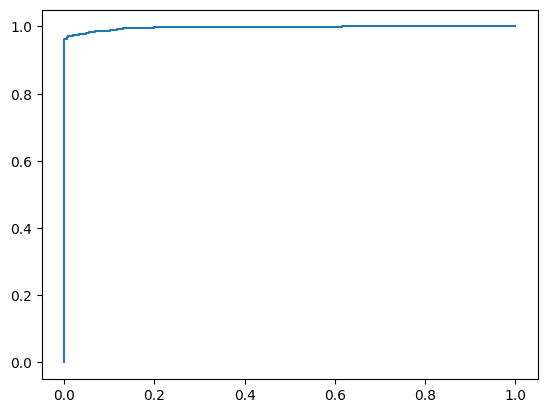

In [27]:
pyplot.plot(fpr, tpr)

In [28]:
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)[0][1]

In [29]:
optimal_proba_cutoff

-3951.605712890625

В целом здесь еще необходимо покопаться в конкретных классах, так как метрики смотрел в целом по интентам и смотреть где сильно может проседать классификатор. Также лучше бы иметь более близкий датасет, возможно с теми  

интентами, которые не реализованы в голосовом помощнике для более точечного отделения ood. Также здесь довольно большое поле для экспериментов, те статьи, которые я почитал на данную тему предлагают довольно большой пласт  
вариантов обучения модели как с ood, так и без него, как в реализованном выше варианте, но я остановился на данном варианте из-за отсутствия ood.  

А так, это конечно только часть из необходимых экспериментов и проверки гипотез, так как иначе тестовое задание не будет иметь конца :)